# Asian Option Example

Author: Fred J. Hickernell + ChatGPT

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vz}{\boldsymbol{z}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/KeisterExample.ipynb?flush_cache=true)

In [1]:
# Colab-only setup
if "google.colab" in str(get_ipython()):
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop

### Import needed packages and initialize some parameters

In [2]:
import sys
import time
from pathlib import Path
import numpy as np
from scipy import stats
import qmcpy as qp
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
REPO_ROOT = Path.cwd().resolve().parent  # Ensure repo root is on sys.path (for local 'classlib' and 'nbviz')
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from classlib.options.asian import bm_transform, asian_arith_mean_call_payoff, price, price_rqmc
from classlib.plots import plot_middle_half_sample_mean, plot_multiple_middle_half_sample_means
import classlib.nbviz as nb
nb.init(use_tex=True)     # styling, Tol cycle, CSS
colors, TINY = nb.TOL_BRIGHT, nb.TINY

## Asian Arithmetic Mean Option
Brownian motions are used in financial modeling.  If 
- $S_0$ is the initial price of a stock/asset
- $r$ is the interest rate
- $\sigma$ is the volatility
Then
$$
S(t) = S_0 \exp\bigl((r -\sigma^2/2)t  + \sigma B(t) \bigr)
$$
is a _geometric Brownian motion_ model of the stock price.

The payoff of an Asian Arithmetic Mean call option is
$$ 
\max\left(\frac 1T \int_0^T S(t) \mathrm{d} t - K, 0 \right) \exp(-rT)
$$ 
where $T$ is the time to maturity and $K$ is the strike price.  We can approximate this integral by the trapezoidal rule.

Below is a function that computes an discounted option payoff for an Asian arithmetic mean call.

In [9]:
# Asian Option Parameters
T=1 #time to expiration
d=13 #number of time steps (52 weeks in a year)
S0=80 #initial stock price
r=0.03 #interest rate
sigma=0.7 #volatility
K=100 #strike price
A = bm_transform(T=T, d=d) #square root of the covariance matrix for a Brownian motin

In [10]:
def make_configs(use_cv=False, drifts=[0], cv_only_iid=True):
    """
    Build a configs dict for plot_multiple_middle_half_sample_means.

    Parameters
    ----------
    use_cv : bool or list[bool], default False
        If True, request control variate. If a list (e.g. [False, True]),
        build both variants.
    drifts : list[float], default [0]
        Constant drift values (0 means no IS).
    cv_only_iid : bool, default True
        If True, apply CV only to IID configs; Sobol configs ignore CV.

    Returns
    -------
    configs : dict
        {key: {"sampler": callable, "f": callable, "label": str}}
    """
    # Normalize to list
    if isinstance(use_cv, (bool, np.bool_)):
        use_cv_list = [use_cv]
    else:
        use_cv_list = list(use_cv)

    sampler_list = [
        ("IID",   lambda n: np.random.random((n, d))),
        ("Sobol", lambda n: qp.Sobol(dimension=d, randomize=True).gen_samples(n)),
    ]

    configs = {}
    for s_name, sampler in sampler_list:
        for drift in drifts:
            use_drift = None if drift == 0 else drift
            for cv_flag in use_cv_list:
                # Enforce: CV only for IID (if requested)
                cv_for_this = (cv_flag and (s_name == "IID")) if cv_only_iid else cv_flag

                # Labels/keys
                suffix = (" + CV" if cv_for_this else "")
                if len(drifts) > 1:
                    key   = f"{s_name}{suffix}, theta={drift:g}"
                    label = rf"{s_name}{' + CV' if cv_for_this else ''}, $\theta={drift:g}$"
                else:
                    key   = f"{s_name}{suffix}"
                    label = f"{s_name}{suffix}"

                # Payoff function (CV toggled per-sampler)
                f = (lambda X, use_drift=use_drift, cv_for_this=cv_for_this:
                     asian_arith_mean_call_payoff(
                         X, S0, r, sigma, T, K, drift=use_drift, A=A,
                         use_control_variate=cv_for_this
                     ))

                configs[key] = {"sampler": sampler, "f": f, "label": label}
    return configs

def plot_zoomed_means(info, n_right, title="Zoomed-in view", frac=0.15, figsize=(12, 4.5)):
    """
    Plot zoomed-in running means with middle-half bands.

    Parameters
    ----------
    info : dict
        Output dict from plot_multiple_middle_half_sample_means (each value should
        have keys "n", "median", "q25", "q75", and optionally "display_label"/"color").
    n_right : int
        Rightmost x-axis limit (usually the maximum sample size n).
    title : str, default="Zoomed-in view"
        Plot title.
    frac : float, default=0.10
        Fractional zoom window around median(final medians); e.g., 0.1 → ±10%.
    figsize : tuple, default=(12, 4.5)
        Figure size in inches.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes objects.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # --- draw each line + shaded IQR region ---
    for key, data in info.items():
        n_vals = data["n"]
        med = data["median"]
        q25 = data["q25"]
        q75 = data["q75"]
        label = data.get("display_label", key)
        color = data.get("color", None)
        ax.fill_between(n_vals, q25, q75, alpha=0.20, color=color)
        ax.plot(n_vals, med, label=label, color=color)

    # --- x-axis: log scale and limits ---
    ax.set_xscale("log", base=10)
    ax.set_xlim(1000, n_right)

    # --- y-axis: zoom window centered at median of final medians ---
    final_meds = [d["median"][-1] for d in info.values()]
    m = np.median(final_meds)
    ax.set_ylim((1 - frac) * m, (1 + frac) * m)

    # --- labels, title, legend, layout ---
    ax.set_xlabel(r"Number of samples $n$")
    ax.set_ylabel(r"Running sample mean $\hat{\mu}_n$")
    ax.set_title(title)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    fig.subplots_adjust(right=0.75)
    fig.tight_layout()

    return fig, ax

## Compare different sampling schemes

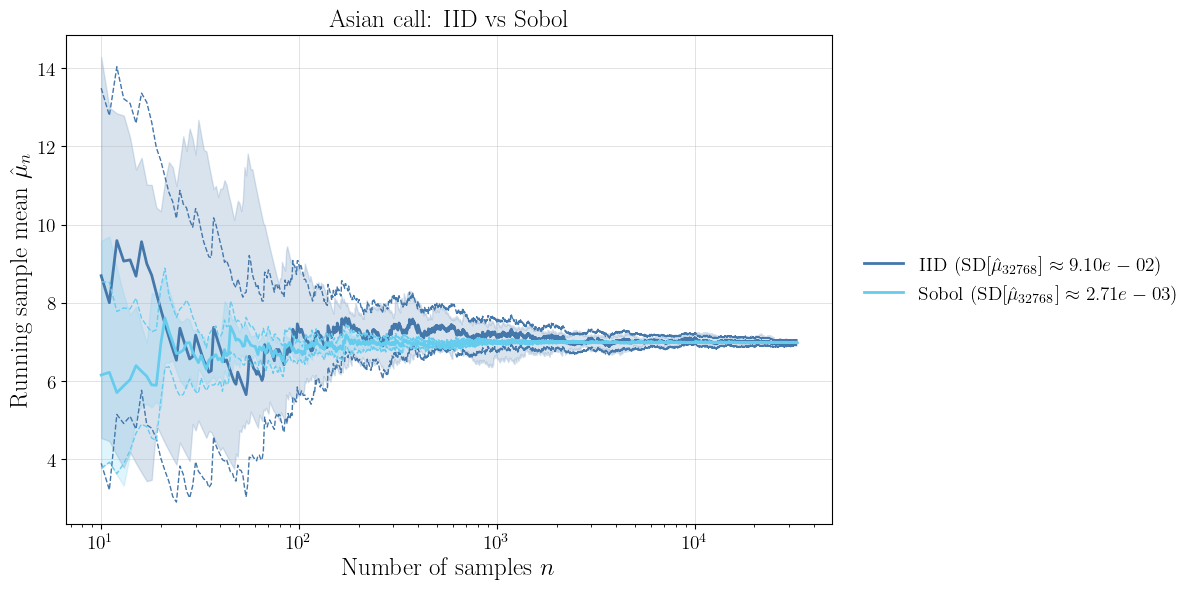

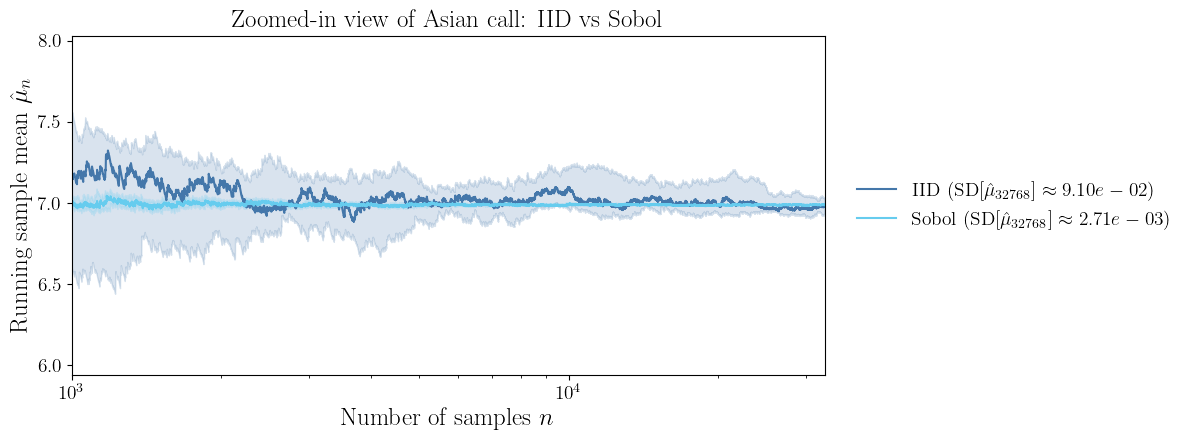

In [11]:
n = 2**15
title="Asian call: IID vs Sobol"
ax_A, info_A = plot_multiple_middle_half_sample_means(make_configs(), title=title)
figA, axA = plot_zoomed_means(info_A, n_right=n, title="Zoomed-in view of "+title)

## Importance sampling via a drift

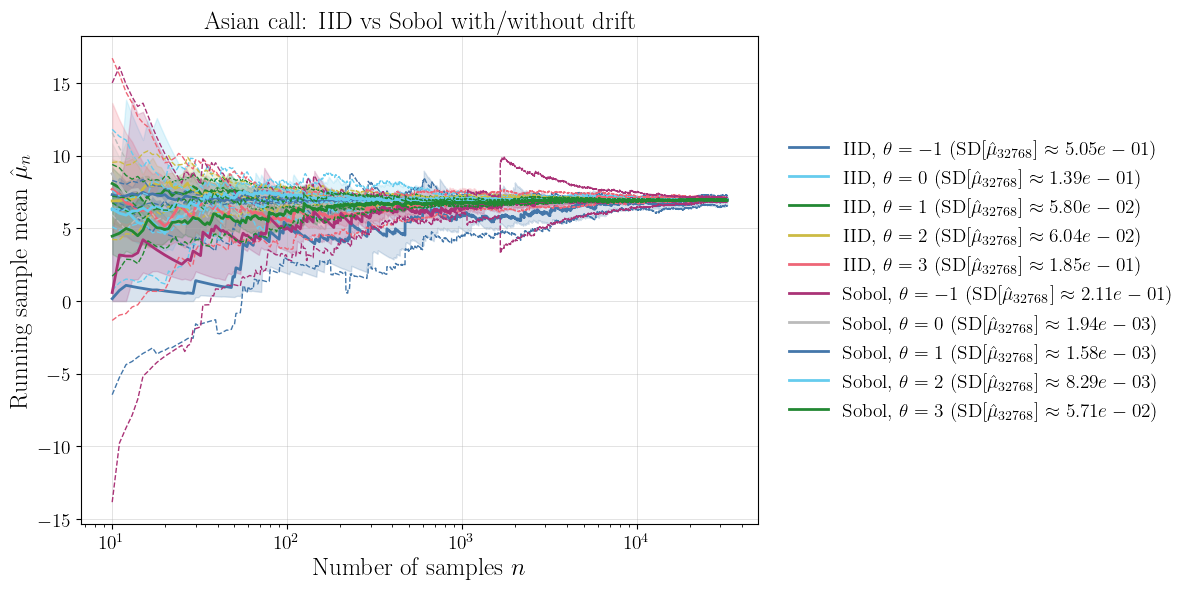

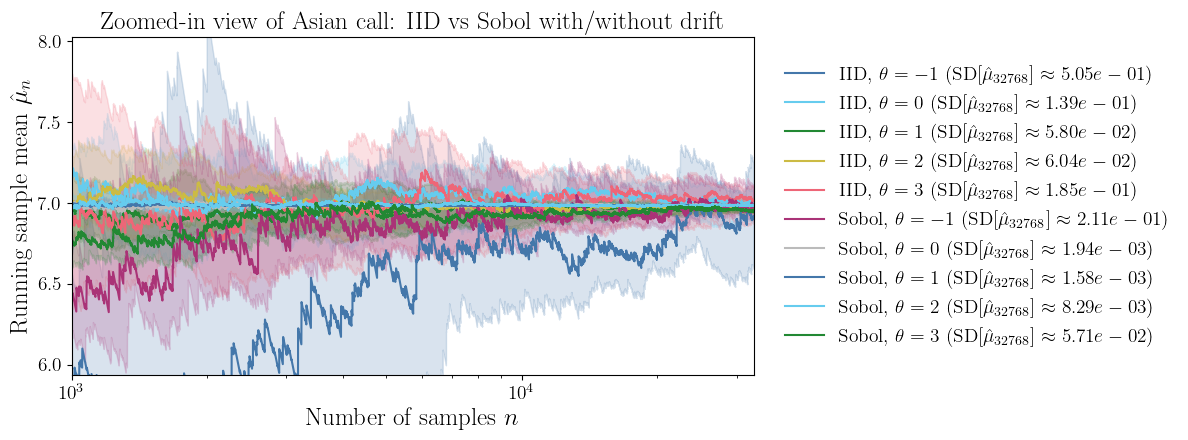

In [12]:
title="Asian call: IID vs Sobol with/without drift"
ax_IS, info_IS = plot_multiple_middle_half_sample_means(make_configs(drifts=[-1,0,1,2,3]), title=title)
figIS, axIS = plot_zoomed_means(info_IS, n_right=n, title="Zoomed-in view of "+title)

## European option as a control variate

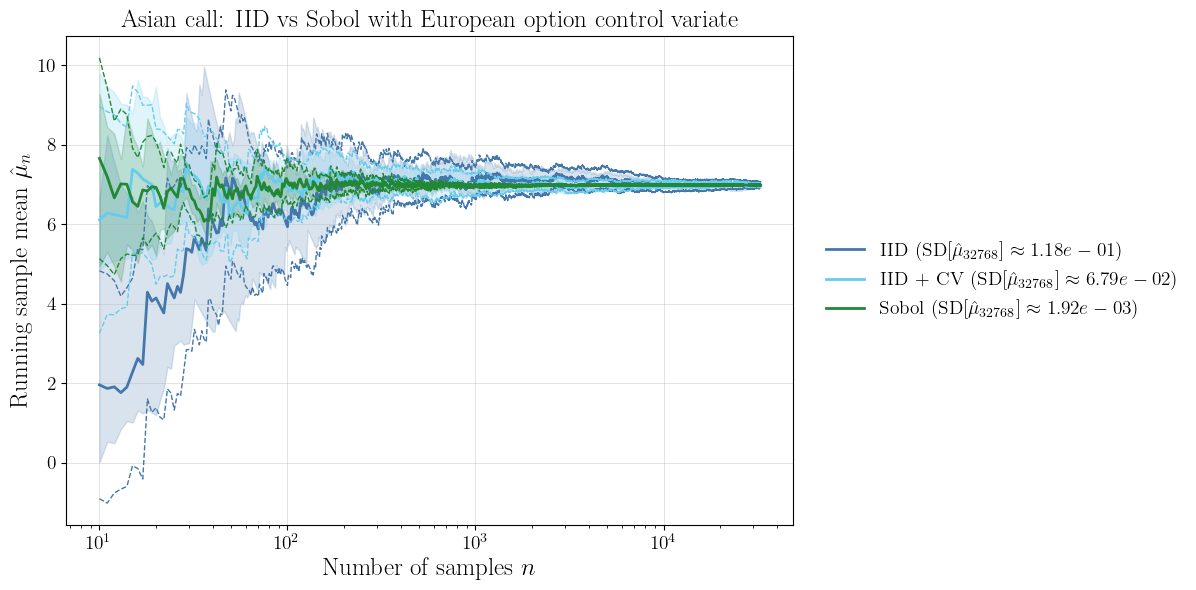

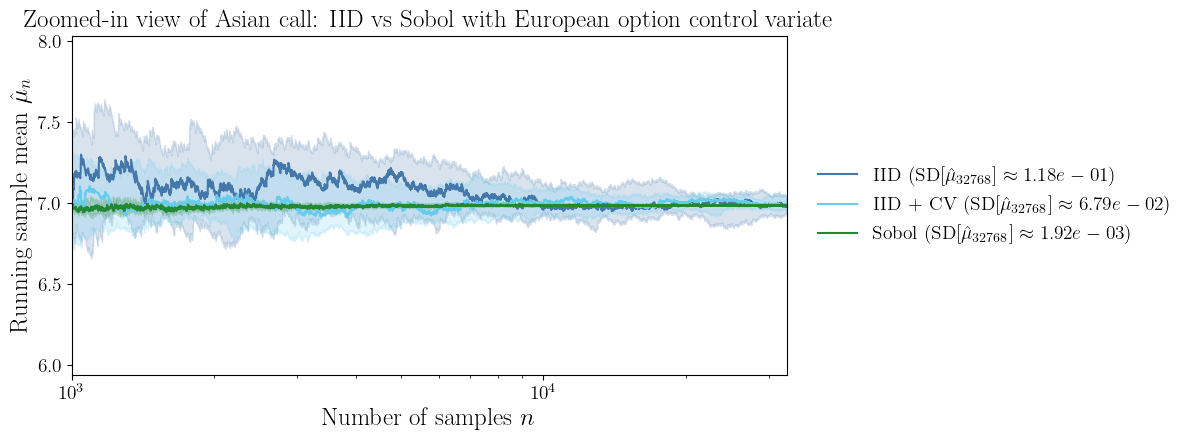

In [7]:
title="Asian call: IID vs Sobol with European option control variate"
ax_CV, info_CV = plot_multiple_middle_half_sample_means(make_configs(use_cv=[False,True]), title=title)
figCV, axCV = plot_zoomed_means(info_CV, n_right=n, title="Zoomed-in view of "+title)

## Drift + European option as a control variate

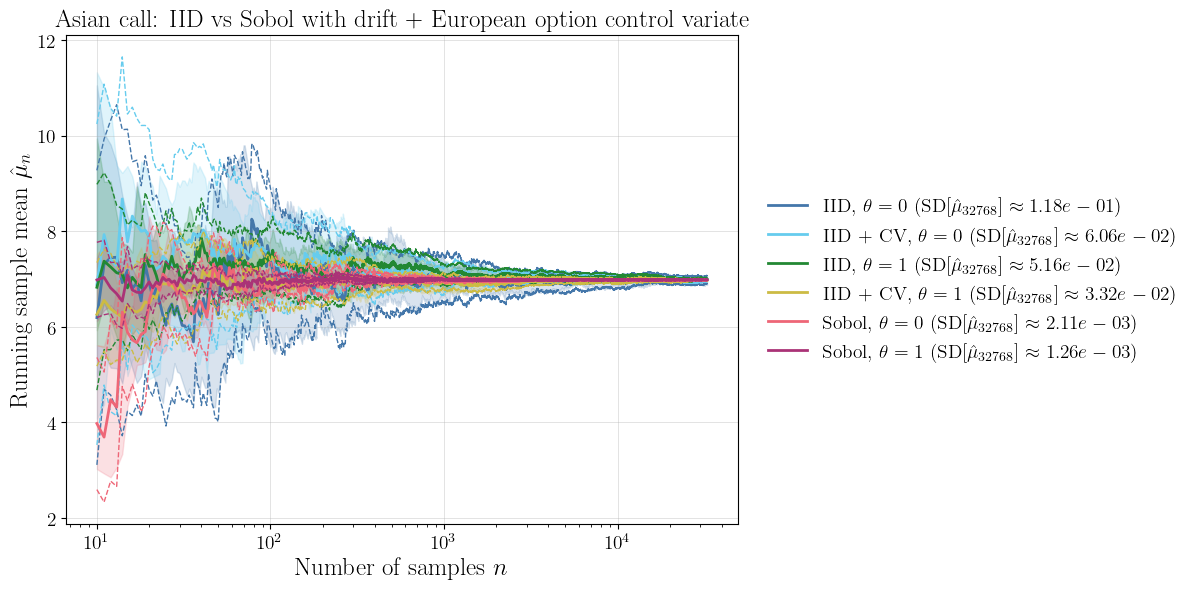

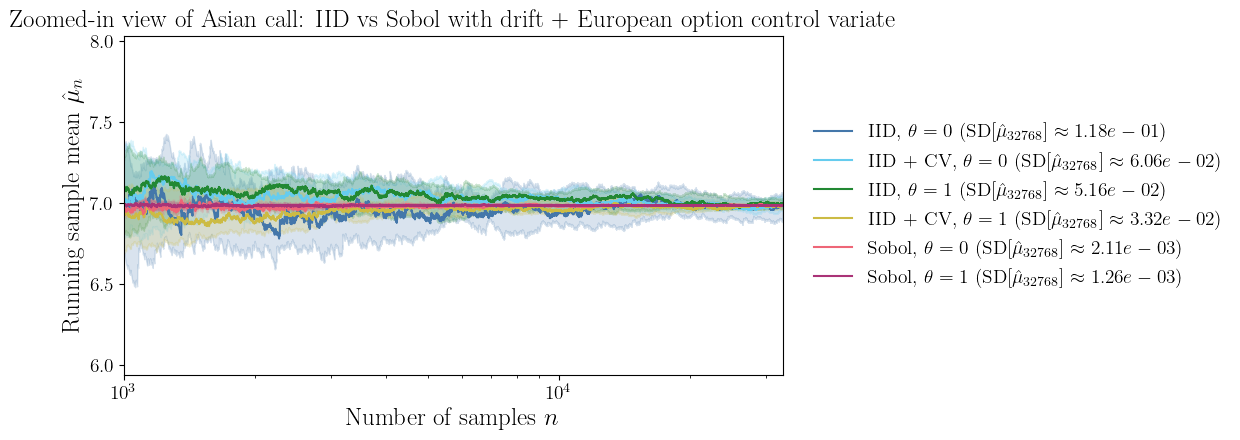

In [8]:
title="Asian call: IID vs Sobol with drift + European option control variate"
ax_IS_CV, info_IS_CV = plot_multiple_middle_half_sample_means(make_configs(use_cv=[False,True],drifts=[0,1]), title=title)
figISCV, axISCV = plot_zoomed_means(info_IS_CV, n_right=n, title="Zoomed-in view of "+title)